# Analysis

In [3]:
import torch
torch.__version__

'1.8.1+cu102'

In [4]:
import numpy as np
import torch
import torch.distributions as td
import probabll.distributions as pd
import matplotlib.pyplot as plt
import torch.nn as nn

In [5]:
from collections import namedtuple, OrderedDict, defaultdict
from tqdm.auto import tqdm
from itertools import chain
from tabulate import tabulate
import pickle

In [6]:
import sys
sys.path.append("../")

In [7]:
from pathlib import Path

In [8]:
from components import GenerativeModel, InferenceModel, VAE
from data import load_mnist
from hparams import load_cfg, make_args
from main import make_state, get_batcher, validate

In [9]:
from analysis import compare_marginals, compare_samples

# Load model and data

* Load hyperparameters
* Load model state
* Load MNIST data

In [10]:
num_samples = 100

In [11]:
model_type = 'categorical'
experiment = 'lively-smoke-26'
directory = f'../trained_models/{model_type}/{experiment}/'
args = make_args(
    load_cfg(
        f"{directory}/cfg.json", 
        # use this to specify a decide for analysis
        device='cuda:1',
        # use this to change paths if you need
        data_dir='../tmp',
    )
)
args

Overriding device to user choice cuda:1
Overriding data_dir to user choice ../tmp


Config(seed=10, batch_size=100, height=28, width=28, output_dir='trained_models/categorical/lively-smoke-26', data_dir='../tmp', device='cuda:1', y_dim=10, z_dim=0, prior_f='categorical 0.0', hidden_dec_size=500, posterior_f='categorical', prior_y='identity', posterior_y='identity', mean_field=True, hidden_enc_size=500, epochs=500, num_samples=100, gen_opt='adam', gen_lr=1e-05, gen_l2=0.0, gen_p_drop=0.0, inf_opt='adam', inf_lr=0.0001, inf_l2=1e-06, inf_p_drop=0.1, grad_clip=1.0, exact_marginal=True, wandb_freq=10, prior_z='gaussian 0.0 1.0', posterior_z='gaussian', shared_enc_fy=True, training_samples=1, lr_warmup=100, load_ckpt=None, reset_opt=False, exact_KL_Y=False, use_self_critic=False, use_reward_standardisation=False, tqdm=False, cfg='cfg/iclr-categorical.json', project='iclr-submission', ppo_like_steps=0, gsp_cdf_samples=100, gsp_KL_samples=1)

In [12]:
plots_dir = Path(f"pdfplots/{model_type}/{experiment}")
plots_dir

PosixPath('pdfplots/categorical/lively-smoke-26')

In [13]:
plots_dir.mkdir(parents=True, exist_ok=True)

In [14]:
args.device

'cuda:1'

In [15]:
state = make_state(
    args, 
    device=args.device, 
    # change this to .best if you want the best ckpt (rather than the last)
    ckpt_path=f"{directory}/ckpt.last"
    #ckpt_path=f"{directory}/training.ckpt"
)

In [16]:
train_loader, valid_loader, test_loader = load_mnist(
    args.batch_size, 
    save_to=args.data_dir, 
    height=args.height, 
    width=args.width
)

Let's check the validation results:

In [17]:
val_metrics = validate(state.vae, get_batcher(valid_loader, args), 1000, progressbar=True, compute_DR=True)
print(f'Saved ckpt - Validation: nll={val_metrics[0]:.2f} bpd={val_metrics[1]:.2f}')

  0%|          | 0/50 [00:00<?, ?it/s]

Saved ckpt - Validation: nll=166.08 bpd=23.96


# Samples from prior

Here we draw some sampels from the generative model (via the prior) and anlyse the results. 

To help do it systematically, we use a KNN classifier trained on MNIST. This classifier achieves F1=95% on MNIST test set.

In [18]:
knn_model = pickle.load(open('knnclassifier.pickle', 'rb'))

In [19]:
from analysis import collect_samples

First, we gather samples:

In [20]:
prior, _ = collect_samples(
    state.vae, 
    get_batcher(valid_loader, args), 
    args, 
    num_samples=1, 
    data_sample=True,
    from_prior=True,
    from_posterior=False,
)

In [21]:
x_gen_prior = np.concatenate(prior['x'])
x_gen_prior.shape

(5000, 784)

Then, we classify the model samples using a KNN classifier trained on (actual) MNIST.

In [22]:
knn_pred = knn_model.predict(x_gen_prior)

In [23]:
clustered = defaultdict(list)
for x_, y_ in zip(x_gen_prior, knn_pred):
    clustered[y_].append(x_)
clustered = {cls: np.stack(digits) for cls, digits in clustered.items()}

In [24]:
p_emp = np.array([len(clustered.get(c, []))/x_gen_prior.shape[0] for c in range(10)])

Let's check a grid of plots with model samples grouped by predicted class:

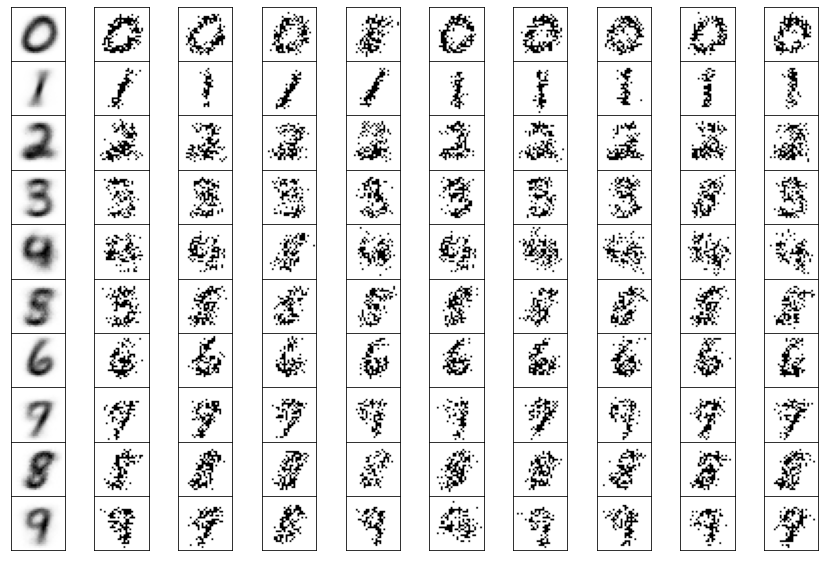

In [25]:
fig, axs = plt.subplots(
    10, 10, 
    figsize=(15, 10),
    sharex=True, sharey=True,
    gridspec_kw={'hspace': 0, 'wspace': 0},
)
for c in range(10):
    axs[c, 0].imshow(clustered.get(c, np.zeros((1, 28 * 28))).mean(0).reshape(args.height, args.width), cmap='Greys')    
    for i, k in enumerate(np.random.choice(len(clustered.get(c, [])), size=9)):
        axs[c, i + 1].imshow(clustered[c][k].reshape(args.height, args.width), cmap='Greys')

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
#_ = fig.suptitle(r'Samples from prior clustered by KNN classifier with F1=95%')
fig.savefig(plots_dir / 'prior-grid.pdf', bbox_inches='tight')

Let's group the model samples by predicted class and inspect a single 'marginal' plot per class:

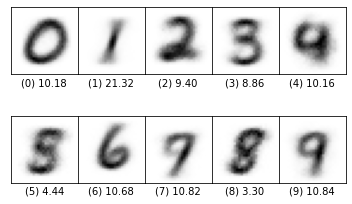

In [26]:
fig, axs = plt.subplots(
    2, 5, 
    sharex=True, sharey=True,
    gridspec_kw={'hspace': 0, 'wspace': 0})
for c in range(10):
    axs[c // 5, c % 5].imshow(clustered.get(c, np.zeros((1, 28 * 28))).mean(0).reshape(args.height, args.width), cmap='Greys')
    axs[c // 5, c % 5].set_xlabel(f"({c}) {p_emp[c] * 100:.2f}") #set_title(f"X'|X={c}")
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
#_ = fig.suptitle(r'Samples from prior clustered by KNN classifier with F1=95%')
fig.savefig(plots_dir / 'prior-marginal.pdf', bbox_inches='tight')

# Training Curves

In [27]:
np_stats_tr = {k: np.array(v) for k, v in state.stats_tr.items()}
np_stats_val = {k: np.array(v) for k, v in state.stats_val.items()}

In [28]:
def smooth(v, kernel_size=100):
    if kernel_size is None:
        return v
    return np.convolve(v, np.ones(kernel_size)/kernel_size, 'valid')

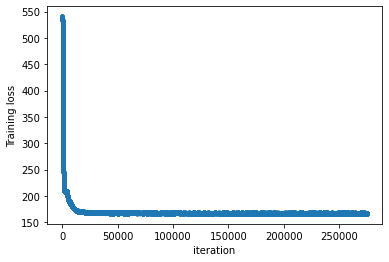

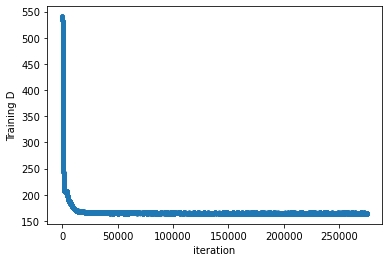

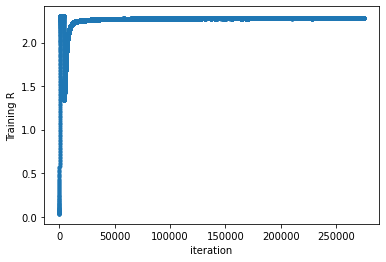

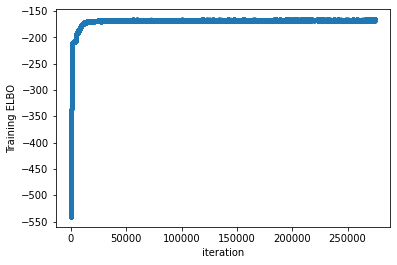

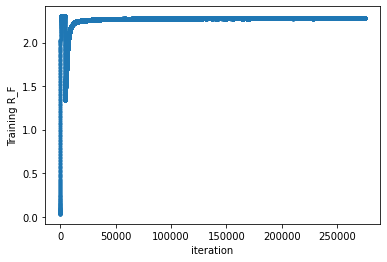

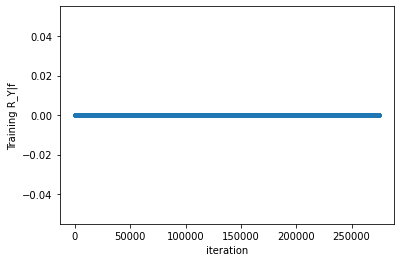

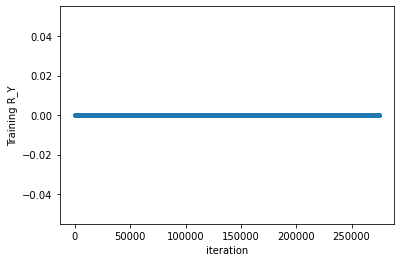

In [29]:
for k, v in np_stats_tr.items():
    v = smooth(v)
    plt.plot(np.arange(1, v.size + 1), v, '.')    
    plt.ylabel(f'Training {k}')
    plt.xlabel('iteration')
    plt.show()

# Validation Curves

In [30]:
print(tabulate(
    [(k, np.mean(v[-100:]), np.min(v[-100:])) for k, v in np_stats_val.items()],
    headers=['metric', 'mean', 'min']
))

metric           mean         min
---------  ----------  ----------
val_nll     166.074     165.914
val_bpd      23.9595     23.9363
val_ELBO   -166.114    -166.249
val_D       163.834     163.664
val_R         2.27925     2.27559
val_R_F       2.27925     2.27559
val_R_Y|f     0           0


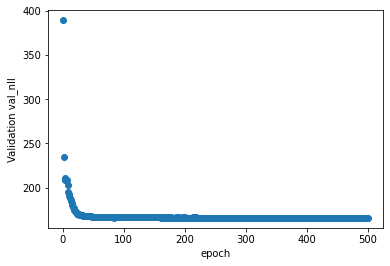

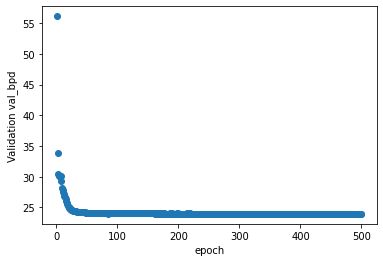

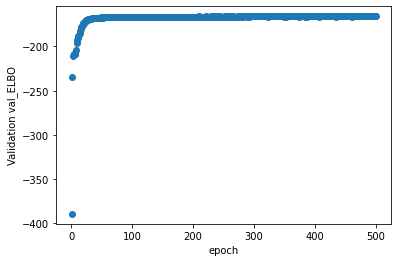

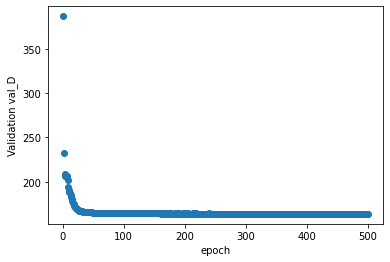

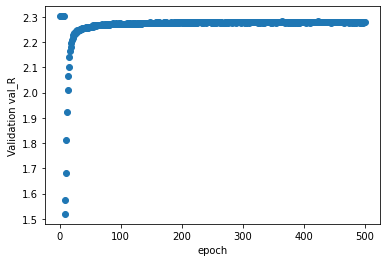

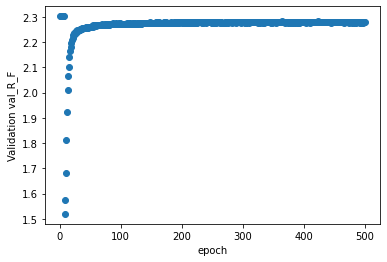

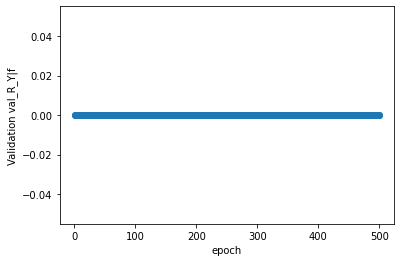

In [31]:
for k, v in np_stats_val.items():
    plt.plot(np.arange(1, v.size + 1), v, 'o')
    plt.ylabel(f'Validation {k}')
    plt.xlabel('epoch')
    plt.show()

In [32]:
rows = [('IS-NLL', val_metrics[0], None), ('IS-BPD', val_metrics[1], None)]
val_DR = val_metrics[2]
for k, v in val_DR.items():
    rows.append((k, v.mean(), v.std()))
print(tabulate(rows, headers=['metric', 'mean', 'std']))    

metric          mean         std
--------  ----------  ----------
IS-NLL     166.084
IS-BPD      23.9609
ELBO      -166.117    47.477
D          163.835    47.4862
R            2.28134   0.0999211
R_F          2.28134   0.0999211
R_Y|f        0         0


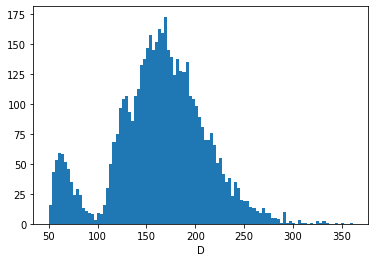

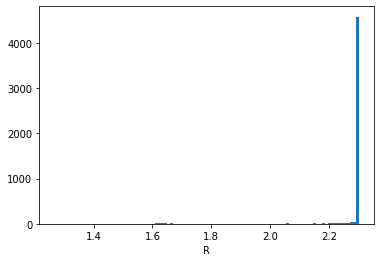

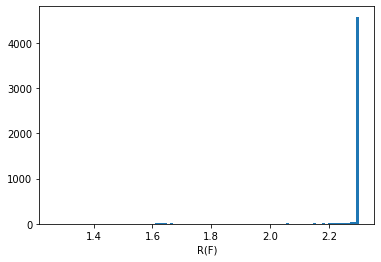

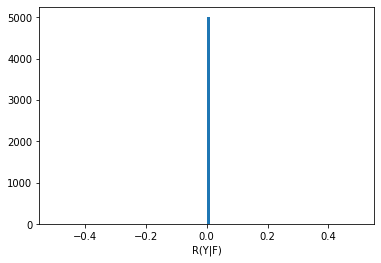

In [39]:
_ = plt.hist(val_DR['D'], bins=100)
_ = plt.xlabel('D')
plt.show()

_ = plt.hist(val_DR['R'], bins=100)
_ = plt.xlabel('R')
plt.show()

if state.vae.p.z_dim:
    _ = plt.hist(val_DR['R_Z'], bins=100)
    _ = plt.xlabel('R(Z)')
    plt.show()
    
if state.vae.p.y_dim:
    _ = plt.hist(val_DR['R_F'], bins=100)
    _ = plt.xlabel('R(F)')
    plt.show()

    _ = plt.hist(val_DR['R_Y|f'], bins=100)
    _ = plt.xlabel('R(Y|F)')
    plt.show()

# Analysis

It's good to check that the aggregated posterior is reasonably close to the prior, when this is not the case, we might need to check the VAE. It's not obvious what might cause such a thing, but it could be due to local optimality, which in turn may be due to too noisy gradient estimates. 

In [40]:
import torch_two_sample as t2s
from analysis import collect_samples

In [41]:
prior, posterior = collect_samples(state.vae, get_batcher(valid_loader, args), args, num_samples=100)

When thing we can do is to check a test statistics, such as MMD, low values indicate the two samples are closer, though note MMD cannot be used to 'accept' the null hypothesis (that the two samples come from the same distribution). Take this as just a sanity check, not as a certificate. 

It's unclear what hyperparameters to use, so we compute the MMD statistic over a range of values and plot the distribution of results:

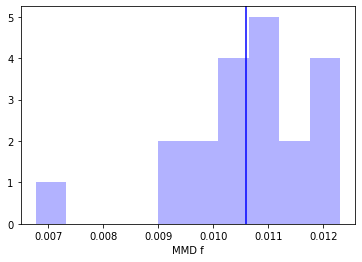

In [42]:
for rv, dim in [('f', state.p.y_dim)]:
    if dim == 0:
        continue
    p_f = np.stack(prior[rv]).reshape(-1, dim)
    q_f = np.stack(posterior[rv]).reshape(-1, dim)
    mmd = t2s.statistics_diff.MMDStatistic(p_f.shape[0], q_f.shape[0])
    v = np.array([mmd(torch.tensor(p_f), torch.tensor(q_f), [alpha]).cpu().numpy() for alpha in np.random.gamma(10., 1./10, size=20)])

    _ = plt.hist(v, color='blue', alpha=0.3, label='')
    _ = plt.axvline(x=v.mean(), c='blue')
    _ = plt.xlabel(f"MMD {rv}")
    plt.show()

## KL

For a trained VAE: 
 1. We want to see that KL(Z|x || Z), KL(F|x || F), and KL(Y|f,x || Y|f) are generally > 0 for any x ~ D.


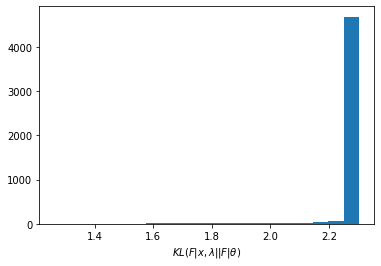

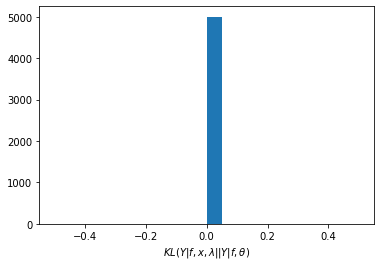

 2. But, marginally, we expect E_X[Z|X] ~ Z E_X[F|X] ~ F and E_FX[Y|F,X] ~ E_F[Y|F].


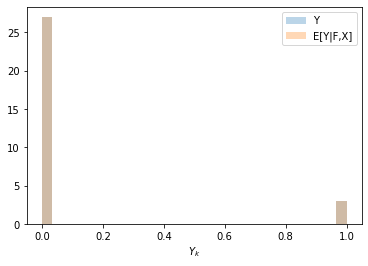

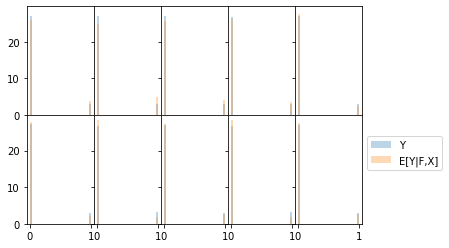

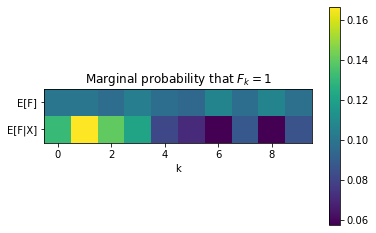

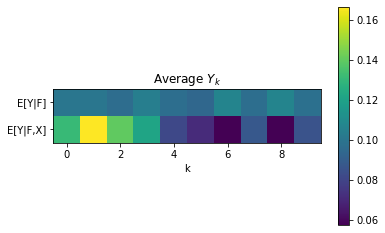

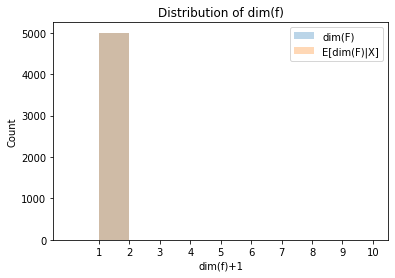

In [43]:
compare_marginals(state.vae, get_batcher(valid_loader, args), args, cols=5, num_samples=num_samples)

## Posterior and Prior Samples

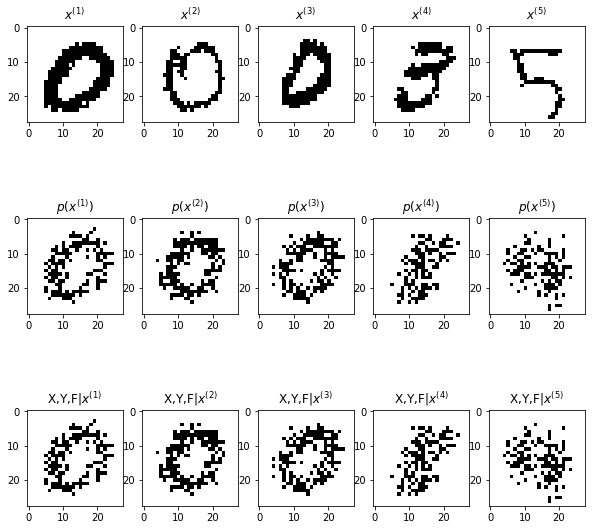

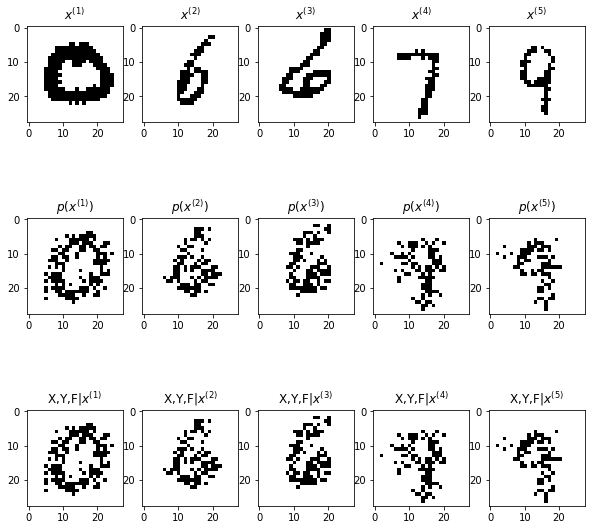

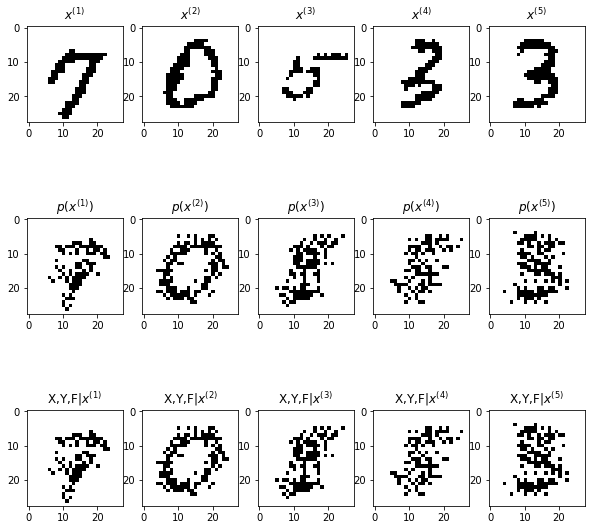

In [44]:
compare_samples(state.vae, get_batcher(valid_loader, args), args, N=5, num_figs=3, num_samples=100, 
                filename=plots_dir / 'posterior-grid')

## TSNE

In [45]:
from analysis import samples_per_digit

In [47]:
f, y, z, x, marginal_f, scores, concs = samples_per_digit(
    state.vae, get_batcher(valid_loader, args, onehot=False), 
    args, return_marginal=False)

In [48]:
f.shape, f.mean(1).shape, z.shape, z.mean(1).shape, x.shape, x.mean(1).shape

((10, 458, 10), (10, 10), (10, 458, 0), (10, 0), (10, 458, 784), (10, 784))

In [49]:
marginal_f.shape, marginal_f.mean(1).shape, scores.shape, scores.mean(1).shape, concs.shape, concs.mean(1).shape

((10, 458, 10), (10, 10), (10, 458, 10), (10, 10), (10, 458, 10), (10, 10))

Let's appreciate the sparsity of the samples

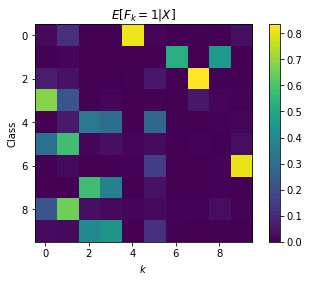

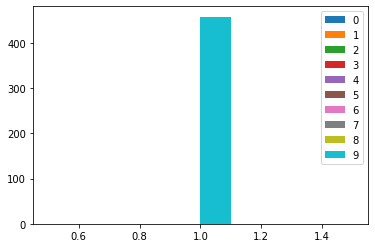

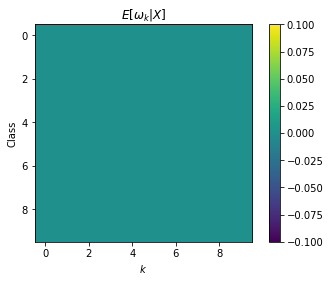

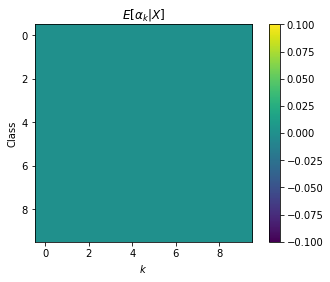

In [50]:
if state.vae.p.y_dim:
    _ = plt.imshow(f.mean(1))
    _ = plt.ylabel('Class')
    _ = plt.xlabel(r'$k$')
    _ = plt.title(r'$E[F_k = 1|X]$')
    _ = plt.colorbar()
    plt.show()
        
    for k in range(10):
        _ = plt.hist(f[k].sum(-1), label=f'{k}')
    _ = plt.legend()
    plt.show()
    
    _ = plt.imshow(scores.mean(1))
    _ = plt.ylabel('Class')
    _ = plt.xlabel(r'$k$')
    _ = plt.title(r'$E[\omega_k|X]$')
    _ = plt.colorbar()
    plt.show()
    
    _ = plt.imshow(concs.mean(1))
    _ = plt.ylabel('Class')
    _ = plt.xlabel(r'$k$')
    _ = plt.title(r'$E[\alpha_k|X]$')
    _ = plt.colorbar()
    plt.show()

In [51]:
from sklearn.manifold import TSNE

Let's appreciate structure in latent space

In [52]:
def tsne_plot(samples, title, legend=True, filename=None):
    """
    :param samples: [10, N,D]
    """
    assert samples.shape[0] == 10, "I need 10 digits"
    D = samples.shape[-1]
    assert D > 0, "0-dimensional features?"
    tsne_results = TSNE(n_components=2, random_state=1).fit_transform(samples.reshape(-1, D)).reshape(10, -1, 2)
    plt.figure(figsize=(6, 5))
    colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'orange', 'purple'
    for i, c in zip(np.arange(10), colors):
        plt.scatter(tsne_results[i, :, 0], tsne_results[i, :, 1], c=c, label=i)
    plt.xticks([], [])    
    plt.yticks([], [])
    if legend:
        #plt.legend(bbox_to_anchor=(1, 0.85), loc='upper left', framealpha=0.5)
        plt.legend(loc='lower right', framealpha=1.0, ncol=2, fontsize='small')
    #plt.title(title)
    
    if filename:
        plt.savefig(f'{filename}.pdf', bbox_inches='tight') 
    plt.show()

    return tsne_results

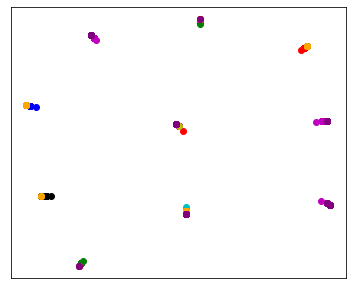

In [53]:
if state.vae.p.y_dim:
    _ = tsne_plot(f, r"$f \sim Q_{F|X=x_{obs}}$", legend=False, filename=plots_dir / 'tsne-f')

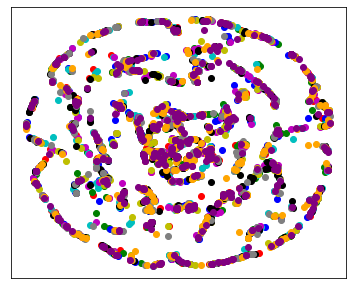

In [54]:
if state.vae.p.y_dim:
    _ = tsne_plot(marginal_f, r"$ \Pr(e_k \in F |X_{obs})$", legend=False, filename=plots_dir /'tsne-mu')    

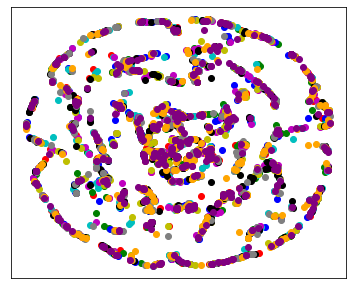

In [55]:
if state.vae.p.y_dim:
    _ = tsne_plot(scores, r"$ w_k \phi_k(f) |X=x_{obs}$", legend=False, filename=plots_dir / 'tsne-scores')    

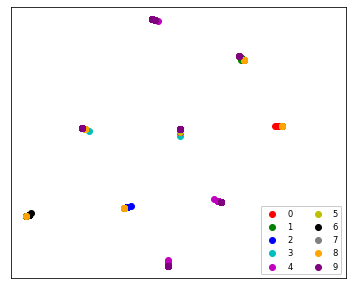

In [56]:
if state.vae.p.y_dim:
    _ = tsne_plot(y, r"$y \sim Q_{Y|X=x_{obs}}$", legend=True, filename=plots_dir / 'tsne-y')

## Marginal samples per class

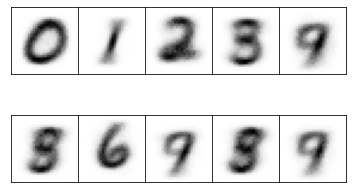

In [57]:
marginal_x = x.mean(1)
fig, axs = plt.subplots(
    2, 5, 
    sharex=True, sharey=True,
    gridspec_kw={'hspace': 0, 'wspace': 0})
for c in range(10):
    axs[c // 5, c % 5].imshow(marginal_x[c].reshape(args.height, args.width), cmap='Greys')
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.savefig(plots_dir / 'posterior-marginal-samples.pdf', bbox_inches='tight')

# Samples from Corner

In [58]:
from analysis import probe_corners

In [59]:
corner_samples = probe_corners(state.vae, get_batcher(valid_loader, args), args, num_samples=100)

In [60]:
corner_samples[0]['x'].shape

(100, 784)

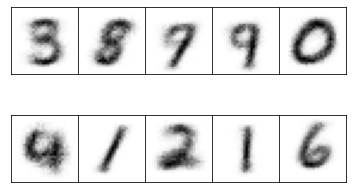

In [61]:
fig, axs = plt.subplots(
    2, 5, 
    sharex=True, sharey=True,
    gridspec_kw={'hspace': 0, 'wspace': 0})
for c in range(10):
    axs[c // 5, c % 5].imshow(corner_samples[c]['x'].mean(0).reshape(args.height, args.width), cmap='Greys')
    #axs[c // 5, c % 5].set_xlabel(c) #set_title(f"X'|X={c}")
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
#_ = fig.suptitle(r'Samples from vertices')  
fig.savefig(plots_dir / 'prior-corner-samples.pdf', bbox_inches='tight')